In [2]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pandas as pd
import numpy as np
import os
import re
import sys
from ijson import items
import json
import pprint
import configparser
from skimage.io import imread 
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

sys.path.append(os.path.abspath('../../Module'))
import preprocessing
import visualize

config = configparser.ConfigParser()
config.read('../../config.ini')

vg_json = config['PATHS']['vg-json']
vg_json_export = config['PATHS']['json-export']
image_dir = config['PATHS']['vg-images']

In [3]:
colors = preprocessing.basic_colors()

## DF mit Test-Split importieren

In [6]:
all_obj = pd.read_csv(vg_json_export+"extracted_data/test_df.csv", index_col=0)#.reset_index(drop=False)

# Frequente Objekte + CDOs + CNOs:
frequent_objects, color_diagnostic_objects, color_biased_objects, color_neutral_objects = preprocessing.freq_cdo_cno(all_obj, num_cdos=100, num_cnos=100, min_num=100)

# all_obj auf frequente Objekte reduzieren
freq_obj = all_obj.loc[all_obj.object_name.isin(frequent_objects)]

# DataFrames für CDOs und CNOs

cd_obj = freq_obj .loc[freq_obj.object_name.isin(color_diagnostic_objects.keys())]
cn_obj = freq_obj.loc[freq_obj.object_name.isin(color_neutral_objects)]

In [8]:
len(frequent_objects)

194

## Label- und Prediction-Arrays importieren

In [5]:
os.listdir(vg_json_export)

['w2c_data.npz',
 'results_type_to_color.npz',
 '.ipynb_checkpoints',
 'vandeweijer2007',
 'extracted_data',
 'pixelwise_rgb_color.npz']

In [6]:
import_arrays = np.load(vg_json_export+'results_type_to_color.npz')
import_arrays.files

['test_y', 'test_x', 'train_y', 'dev_y', 'pred_y', 'dev_x', 'train_x']

In [11]:
predict_y = import_arrays['pred_y']
ids = predict_y[:,0:1]

In [12]:
# wenn id nicht in predictions
ids = import_arrays['test_x'][:,0:1]
predict_y = np.append(ids, predict_y, axis=1)

## Predictions und Test-DF zusammenführen
Resultat: Ein DF pro Bedingung (alle Objekte, CDO, CDO mit Memory Color, CDO ohne Memory Color)

In [18]:
# DataFrame aus Predictions (np-Array) erstellen
predict_df =  pd.DataFrame(data=predict_y[0:,1:],index=predict_y[0:,0],columns=[colors])
# Farbwort mit höchstem Wert (-> prognostiziertes Farbwort) (ergibt pd.Series)
pred_c = predict_df.idxmax(axis=1)
# pred-Series als Column von all_objects
predict_df.columns = [c[0] if type(c) == tuple else c for c in predict_df.columns]
# Tupel in Column-Namen auflösen
predict_df['color_pred'] = predict_df.idxmax(axis=1)
# all_objects mit all_obj (enthält ids, bbs, Objektnamen, Farbattribute) zusammenführen
predict_df = all_obj.join(predict_df, how='inner')

# Types anpassen
predict_df['color']=predict_df['color'].astype(str)
predict_df['color_pred']=predict_df['color_pred'].astype(str)

In [19]:
predict_cdo = predict_df.loc[cd_obj.index.to_list()]
predict_cno = predict_df.loc[cn_obj.index.to_list()]

## Ergebnisse überprüfen

### Scores

In [20]:
score_all = len(predict_df.loc[predict_df['color'] == predict_df['color_pred']]) / len(predict_df)
score_cdo = len(predict_cdo.loc[predict_cdo['color'] == predict_cdo['color_pred']]) / len(predict_cdo)
score_cno = len(predict_cno.loc[predict_cno['color'] == predict_cno['color_pred']]) / len(predict_cno)

print('All Objects: {a}, Color-Diagnostic Objects: {b}, Color-Neutral Objects: {c}'.format(a=score_all, b=score_cdo, c=score_cno))

All Objects: 0.4913945507487521, Color-Diagnostic Objects: 0.7350509391566133, Color-Neutral Objects: 0.30510667132091746


### Alle Objekte

In [21]:
predict_df.loc[predict_df['color'] != predict_df['color_pred']].sort_values('object_name')\
    .sample(n=5)

bb_h  bb_w  bb_x  bb_y   color  image_id  object_id object_name  \
368169.0    15    58    85    63    blue   2374850     724735     glasses   
197803.0    43    64   146   139   black   2397615     663426         car   
187779.0   172   498     1   166   brown   2398916     420857       water   
368129.0    76    34   370   297  yellow   2374856     585321       lines   
753271.0    18    18   347   138     red   2329163    2836552       shirt   

             black      blue     brown      gray     green    orange  \
368169.0  0.777814  0.031924  0.072229  0.003178  0.003234  0.009410   
197803.0  0.224889  0.125748  0.012342  0.057321  0.033657  0.008328   
187779.0  0.011066  0.548861  0.080326  0.039306  0.147683  0.000849   
368129.0  0.051205  0.019711  0.004602  0.006246  0.006807  0.011016   
753271.0  0.147580  0.190044  0.019927  0.032880  0.062838  0.034142   

              pink    purple       red     white    yellow color_pred  
368169.0  0.015172  0.009808  0.047639  0.016612  0.012981      black  
197803.0  0.001445  0.002526  0.199856  0.289887  0.044001      white  
187779.0  0.001094  0.001010  0.000889  0.166282  0.002634       blue  
368129.0  0.001276  0.000393  0.020745  0.697109  0.180890      white  
753271.0  0.041054  0.016981  0.116324  0.290841  0.047390      white

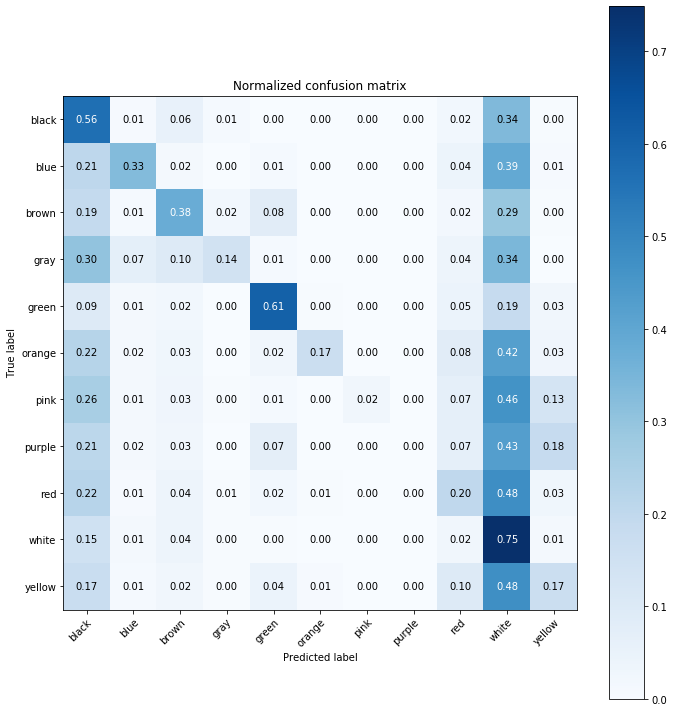

In [22]:
plot_confusion_matrix(predict_df.color, predict_df.color_pred, classes=colors, normalize=True)

In [23]:
len(predict_df.loc[predict_df['color'] == predict_df['color_pred']].sort_values('object_name')\
    .loc[predict_df['color'] == 'black']
   )

15283

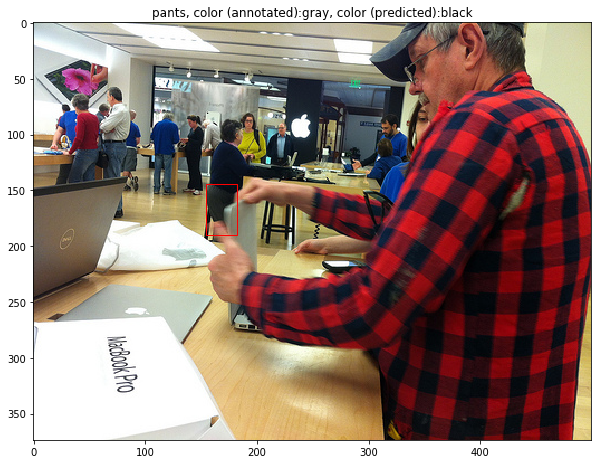

501771.0    None
dtype: object

In [24]:
predict_df.loc[predict_df['color'] != predict_df['color_pred']].sort_values('object_name')\
    .sample(n=1)\
    .apply(lambda x:plot_object(x, image_dir), axis=1)

### Color Diagnostic Objects

In [25]:
predict_cdo.loc[predict_cdo['color'] != predict_cdo['color_pred']].sort_values('object_name')\
    .sample(n=5)

bb_h  bb_w  bb_x  bb_y   color  image_id  object_id object_name  \
79991     85   495     2     3    gray   2411385     312665         sky   
496277    63   111   233   158  yellow   2360139    2187446         van   
81488    298   244    56    14     red   2411204    1081830        hair   
270142    48    39    77   181   black   2387672     511859       clock   
352202   129   166    34   206    gray   2376706     570369    keyboard   

           black      blue     brown      gray     green    orange      pink  \
79991   0.007738  0.860821  0.000580  0.045305  0.000364  0.004568  0.002450   
496277  0.070004  0.073000  0.008959  0.030840  0.031333  0.009348  0.002258   
81488   0.329538  0.002211  0.488649  0.046209  0.001643  0.003772  0.002525   
270142  0.273027  0.038792  0.044874  0.008045  0.030022  0.006350  0.002557   
352202  0.486416  0.003562  0.003661  0.031994  0.009929  0.000875  0.001692   

          purple       red     white    yellow color_pred  
79991   0.001176  0.001373  0.073798  0.001828       blue  
496277  0.004869  0.075133  0.653917  0.040338      white  
81488   0.002335  0.068735  0.052583  0.001799      brown  
270142  0.002361  0.024383  0.543287  0.026302      white  
352202  0.000781  0.004582  0.454697  0.001811      black

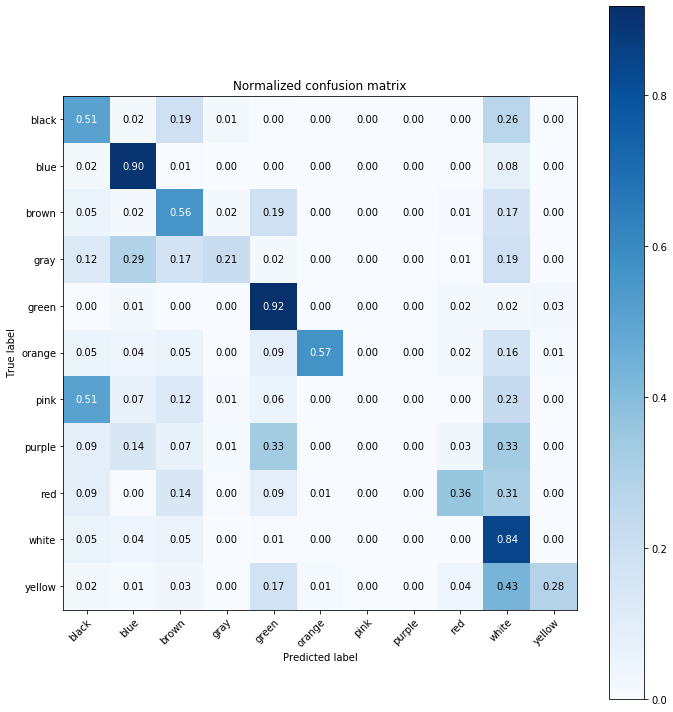

In [26]:
plot_confusion_matrix(predict_cdo.color, predict_cdo.color_pred, classes=colors, normalize=True)

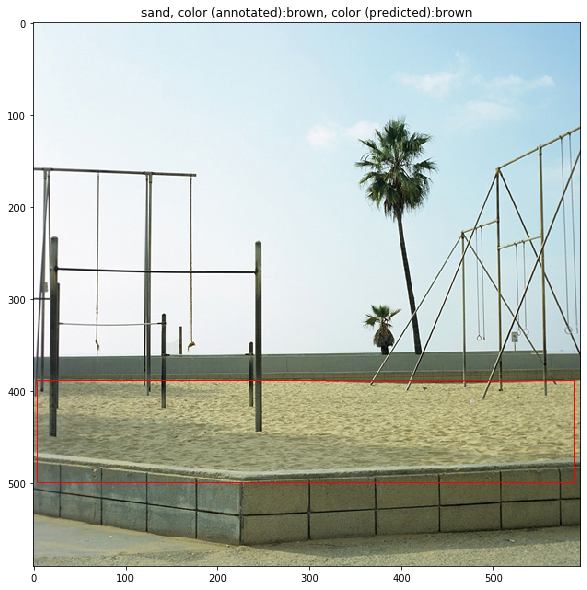

1824    None
dtype: object

In [27]:
predict_cdo.loc[predict_cdo['color'] == predict_cdo['color_pred']].sort_values('object_name')\
    .sample(n=1)\
    .apply(lambda x:plot_object(x, image_dir), axis=1)